# Imports

In [1]:
import jax
import jax.numpy as np

from jax.random import split, PRNGKey

from jax.config import config
config.update('jax_debug_nans', True)

### NOTE: f32 gives > 3x speedup wrt f64
#config.update('jax_enable_x64', True)

In [2]:
from jax_md import space

In [3]:
import jax_morph

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate

from jax_morph.datastructures import CellState, SpaceFunc
from jax_morph.simulation import simulation, sim_trajectory

from jax_morph.cell_division import S_cell_division
from jax_morph.cell_growth import S_grow_cells

from chem_twotypes.mechanical import S_mechmin_twotypes
from chem_twotypes.secdiff import S_ss_chemfield
from chem_twotypes.divrates import S_set_divrate

from chem_twotypes.initial_states import init_state_grow

In [4]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.9'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [5]:
import matplotlib.pyplot as plt

from tqdm import tqdm

# Set Parameters

In [6]:
ParamsDict = dict

In [7]:
# Define parameters -- blue particles are type 1, orange are type 2
# keep jax type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2


### CELL DIMENSIONS

#change constants in divrate calculation if cellRad != .5 
# always use python scalars
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

#possibly different diffusion and degradation for each chemical
diffCoeff = np.ones(n_chem) #np.array([1.,1.])
degRate = np.ones(n_chem) #np.array([1.,1.])

#diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5


### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = sec_max_unitary*np.ones((n_chem,), dtype=np.float32)
sec_max = sec_max.at[0].set(7.)

sec_gamma = 1.* np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = 0.*np.ones((n_chem,n_chem), dtype=np.float32) 


# DIVISION

div_gamma = 1.*np.ones(n_chem, dtype=np.float32)
div_k = 0.*np.ones(n_chem, dtype=np.float32)
#div_k = div_k.at[0].set(5.)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 2. #orange
eps_OneOne = 2. #blue
eps_OneTwo = 2. 

#morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for Morse potential minimization
mech_relaxation_steps = 100


# Initialization and number of added cells. 
ncells_init = 10 #number of cells in the initial cluster
n_ones_init = 5 #number of type-1 cell in the initail cluster
ncells_add = 150
#ncells_tot =  np.int16(ncells_init+ncells_add)# final number of cells

assert ncells_init > n_ones_init

In [8]:
def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [9]:
train_params = {
    'n_chem': False,
    
    'sec_max': False,
    'sec_gamma': True,
    'sec_k' : True,
    
    'div_gamma' : True,
    'div_k' : True,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : False,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    #'ncells_tot': ncells_tot,
    'ncells_add': False,
}

In [10]:
params = {
    'n_chem': n_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    #'ncells_tot': ncells_tot,
    'ncells_add': ncells_add,
}

# Simulation

In [11]:
key = PRNGKey(0)

## Generate initial state

In [12]:
# build initial state and space handling functions

fspace = SpaceFunc(*space.free())

key, init_key = split(key)

# generate initial state by growing from single cell
istate = init_state_grow(init_key, params, fspace)

/home/fmottes/.conda/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, name)


## Generate init-apply functions

In [13]:
# functions in this list will be executed in the given order
# at each simulation step
fstep = [
    S_cell_division,
    S_grow_cells,
    S_mechmin_twotypes,
    S_ss_chemfield,
    S_set_divrate
]

sim_init, sim_step = simulation(fstep, params, fspace)

# Optimization

In [14]:
import equinox as eqx

from jax import vmap, value_and_grad

import optax
from optax import adam, sgd

from functools import partial

## Metrics

In [15]:
def diff_avg_divrates(state):
    
    #get index vectors for each type
    ctype_one = np.where(state.celltype==1,1,0)
    ctype_two = np.where(state.celltype==2,1,0)
    
    #get average divrate of each type 
    avdiv_one=np.sum(state.divrate*ctype_one)/np.sum(ctype_one)
    avdiv_two=np.sum(state.divrate*ctype_two)/np.sum(ctype_two)

    diff = avdiv_one-avdiv_two
    
    return diff


def diff_n_ctypes(state, relative=False):
    
    ctype_one = np.where(state.celltype==1,1,0).sum()
    ctype_two = np.where(state.celltype==2,1,0).sum()
    
    diff = ctype_one-ctype_two
    
    if relative:
        diff = diff/np.where(state.celltype!=0,1,0).sum()
    
    return diff

## Losses

In [16]:
from jax import lax

### Simple Loss (no logp)

In [17]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def simple_loss(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=diff_n_ctypes,#diff_avg_divrates, 
            target_metric=0.,
           ):
    '''
    Only calculates the deterministic part of the square loss, does not manage stochastic nodes.
    '''

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)

    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, _ = sim_trajectory(istate, sim_init, sim_step, sim_key)

    # Calculate metric of final structure
    metric_final = metric_fn(fstate)

    # measure difference between final state and target 
    loss = np.sum(np.power(metric_final - target_metric,2))

    return loss

In [18]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def reinforce_loss(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=diff_n_ctypes,#diff_avg_divrates, 
            target_metric=0.,
            GAMMA=.9,
           ):
    '''
    REINFORCE loss with discounting. 
    '''

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)

    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, logp = sim_trajectory(istate, sim_init, sim_step, sim_key)

    # Calculate metric of final structure
    metric_final = metric_fn(fstate)

    # measure difference between final state and target 
    loss = np.sum(np.power(metric_final - target_metric,2))
    
    steps = len(logp)
    discounted_losses = np.array([(GAMMA**(steps-i))*loss for i in np.arange(steps)])
    
    loss = -np.sum(logp*lax.stop_gradient(discounted_losses))

    return loss

In [19]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def combined_loss(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=diff_n_ctypes,#diff_avg_divrates, 
            target_metric=0.,
            GAMMA=.9,
           ):
    '''
    REINFORCE loss with discounting and loss gradient contribution. 
    '''

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)

    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, logp = sim_trajectory(istate, sim_init, sim_step, sim_key)

    # Calculate metric of final structure
    metric_final = metric_fn(fstate)

    # measure difference between final state and target 
    loss = np.sum(np.power(metric_final - target_metric,2))
    
    steps = len(logp)
    discounted_losses = np.array([(GAMMA**(steps-i))*loss for i in np.arange(steps)])
    
    return loss + np.sum(logp*lax.stop_gradient(discounted_losses))

### Ensembling

In [20]:
#@eqx.filter_jit #NO JIT IS FASTER IN THIS CASE
def avg_loss(params, hyper_params, vloss_fn, sim_keys, **kwargs):
    
    lss = vloss_fn(params, hyper_params, sim_key=sim_keys, **kwargs)
    
    return np.mean(lss)

#### Loss distribution

In [21]:
%%time

key, *subkeys = split(key, 101)
subkeys = np.array(subkeys)

p, hp = eqx.partition(params, train_params)

lss = simple_loss(p, hp, fstep, fspace, istate, subkeys)

CPU times: user 12.1 s, sys: 5.59 s, total: 17.7 s
Wall time: 15.2 s


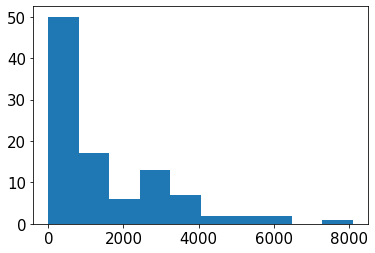

In [22]:
plt.hist(lss.tolist());

In [23]:
np.mean(lss)

DeviceArray(1439.2, dtype=float32)

#### Mean loss grad

In [24]:
%%time

key, *subkeys = split(key, 101)
subkeys = np.array(subkeys)

p, hp = eqx.partition(params, train_params)

l, g = value_and_grad(avg_loss)(p, 
                                 hp, 
                                 simple_loss, 
                                 subkeys, 
                                 fstep=fstep,
                                 fspace=fspace,
                                 istate=istate,
                                )

CPU times: user 9.37 s, sys: 3.36 s, total: 12.7 s
Wall time: 9.8 s


In [25]:
l, g

(DeviceArray(1621.36, dtype=float32),
 {'alpha': None,
  'cellRad': None,
  'cellRadBirth': None,
  'degRate': None,
  'diffCoeff': None,
  'div_gamma': DeviceArray([0., 0.], dtype=float32),
  'div_k': DeviceArray([0., 0.], dtype=float32),
  'eps_OneOne': None,
  'eps_OneTwo': None,
  'eps_TwoTwo': None,
  'mech_relaxation_steps': None,
  'n_chem': None,
  'n_ones_init': None,
  'ncells_add': None,
  'ncells_init': None,
  'r_cutoff': None,
  'r_cutoffDiff': None,
  'r_onset': None,
  'r_onsetDiff': None,
  'sec_gamma': DeviceArray([[0., 0.],
               [0., 0.]], dtype=float32),
  'sec_k': DeviceArray([[0., 0.],
               [0., 0.]], dtype=float32),
  'sec_max': None})

## Initialization

In [26]:
#def add_noise(leaf, ):
    
    

## Optimization loop

In [ ]:
EPOCHS = 500
BATCH_SIZE = 64

LEARNING_RATE = .2



p, hp = eqx.partition(params, train_params)

optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(p)


#store initial params
params_t = [p]


#store loss at initial params
key, *batch_subkeys = split(key, BATCH_SIZE+1)
batch_subkeys = np.array(batch_subkeys)


l, grads = value_and_grad(avg_loss)(p, hp, combined_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)


loss_t = [float(l)]



for t in tqdm(range(EPOCHS), total=EPOCHS):
    
    key, *batch_subkeys = split(key, BATCH_SIZE+1)
    batch_subkeys = np.array(batch_subkeys)
    
    updates, opt_state = optimizer.update(grads, opt_state, p)
    p = eqx.apply_updates(p, updates)
    
    l, grads = value_and_grad(avg_loss)(p, hp, combined_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    
    l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    

    loss_t.append(float(l))
    params_t.append(p)

  2%|▋                                             | 8/500 [02:52<2:56:25, 21.52s/it]

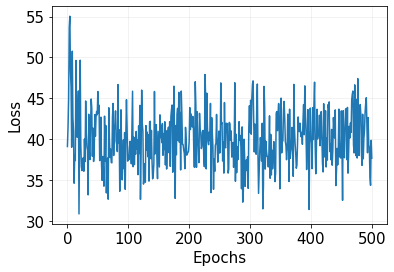

In [54]:
plt.plot(np.sqrt(np.array(loss_t)))
#plt.yscale('log')

plt.grid(alpha=.2)

plt.xlabel('Epochs')
plt.ylabel('Loss');

In [55]:
p

{'alpha': None,
 'cellRad': None,
 'cellRadBirth': None,
 'degRate': None,
 'diffCoeff': None,
 'div_gamma': DeviceArray([3.0632792, 2.701816 ], dtype=float32),
 'div_k': DeviceArray([-1.0043261, -2.422353 ], dtype=float32),
 'eps_OneOne': None,
 'eps_OneTwo': None,
 'eps_TwoTwo': None,
 'mech_relaxation_steps': None,
 'n_chem': None,
 'n_ones_init': None,
 'ncells_add': None,
 'ncells_init': None,
 'r_cutoff': None,
 'r_cutoffDiff': None,
 'r_onset': None,
 'r_onsetDiff': None,
 'sec_gamma': DeviceArray([[1.9397547, 1.941562 ],
              [2.5721912, 2.365567 ]], dtype=float32),
 'sec_k': DeviceArray([[-0.8297174, -0.3543796],
              [-1.4489807, -1.3522599]], dtype=float32),
 'sec_max': None}

### Opt params 

#### Original Size

In [56]:
# merge params dicts
all_params = eqx.combine(p, hp)

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, subkey)

/home/fmottes/.conda/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, name)


In [57]:
# Calculate metric of final structure
diff_avg_divrates(fstate)**2

DeviceArray(0.00034498, dtype=float32)

In [58]:
diff_n_ctypes(fstate)

DeviceArray(54, dtype=int32)

In [59]:
diff_n_ctypes(fstate, relative=True)

DeviceArray(0.3375, dtype=float32)

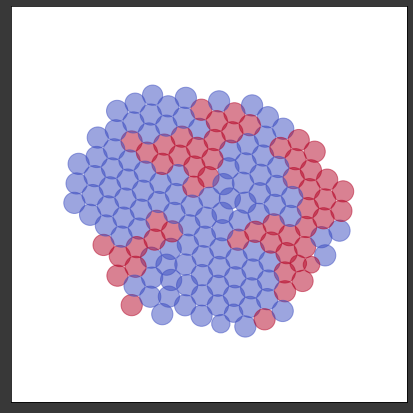

In [60]:
draw_circles_ctype(fstate);

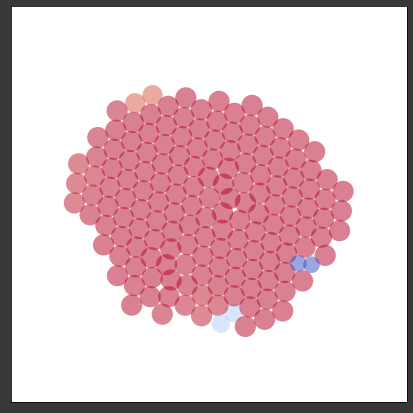

In [61]:
draw_circles_divrate(fstate);

#### Bigger system

In [62]:
# merge params dicts
all_params = eqx.combine(p, hp)

#run bigger simulation
all_params['ncells_add'] = 500

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, key)

In [63]:
# Calculate metric of final structure
diff_avg_divrates(fstate)**2

DeviceArray(2.6509202e-05, dtype=float32)

In [64]:
diff_n_ctypes(fstate, relative=True)

DeviceArray(-0.10980392, dtype=float32)

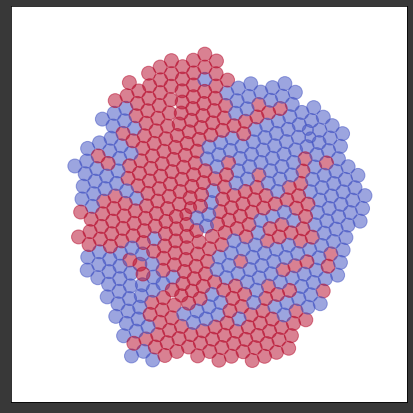

In [65]:
draw_circles_ctype(fstate);

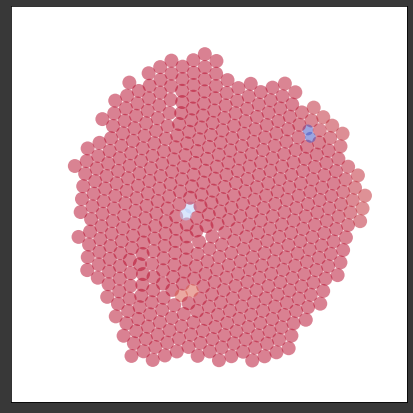

In [66]:
draw_circles_divrate(fstate);

### Initial params 

#### Original size

In [67]:
pp = params.copy()

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, key)

In [68]:
# Calculate metric of final structure
diff_avg_divrates(fstate)**2

DeviceArray(0.00396718, dtype=float32)

In [69]:
diff_n_ctypes(fstate, relative=True)

DeviceArray(-0.0375, dtype=float32)

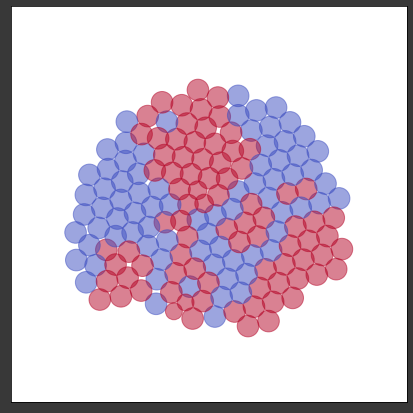

In [70]:
draw_circles_ctype(fstate);

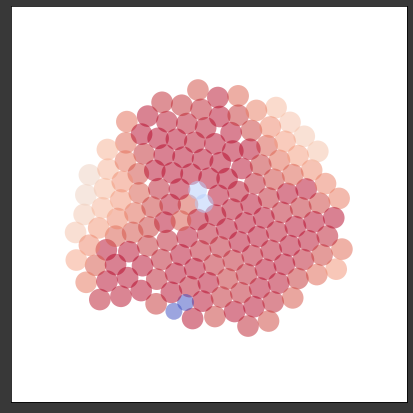

In [71]:
draw_circles_divrate(fstate);

#### Bigger system

In [72]:
pp = params.copy()

#run bigger simulation
pp['ncells_add'] = 500

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, key)

In [73]:
# Calculate metric of final structure
diff_avg_divrates(fstate)**2

DeviceArray(0.03208182, dtype=float32)

In [74]:
diff_n_ctypes(fstate, relative=True)

DeviceArray(0.16862744, dtype=float32)

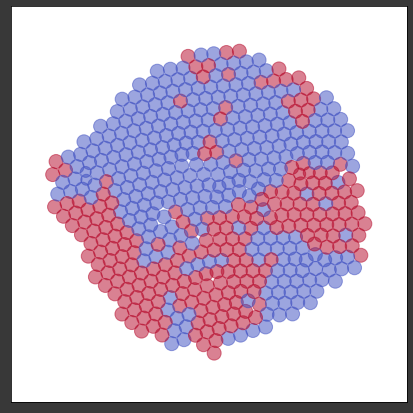

In [75]:
draw_circles_ctype(fstate);

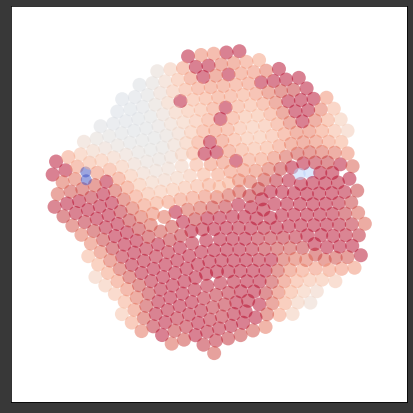

In [76]:
draw_circles_divrate(fstate);

### Curve comparison

In [77]:
from jax_morph.utils import logistic

#### Division

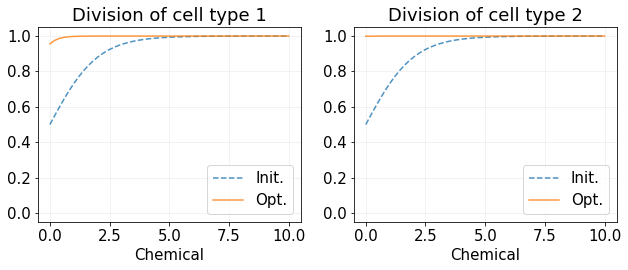

In [78]:
xx = np.linspace(0,10,50)

for ct in range(2):
    
    ax = plt.subplot(1,2,ct+1)
    
    ax.plot(xx, logistic(xx, params['div_gamma'][ct], params['div_k'][ct]), '--', alpha=.8, label='Init.')
    
    ax.plot(xx, logistic(xx, p['div_gamma'][ct], p['div_k'][ct]), alpha=.8, label='Opt.')
    
    ax.set_ylim(-.05, 1.05)
    
    ax.grid(alpha=.2)
    
    ax.set_xlabel('Chemical')
    ax.set_title(f'Division of cell type {ct+1}')

    ax.legend(loc='lower right');
    
    
plt.gcf().set_size_inches(9, 4)
plt.gcf().tight_layout()

#### Secretion

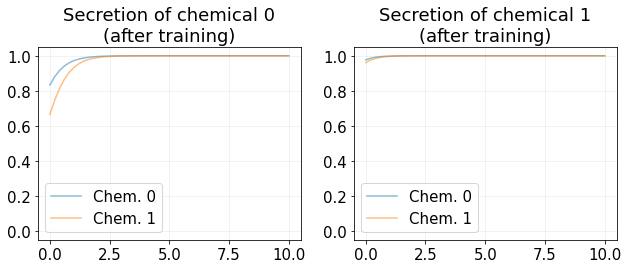

In [79]:
for c in range(2):

    ax = plt.subplot(1,2,c+1)

    ax.plot(xx, logistic(xx, p['sec_gamma'][c,0], p['sec_k'][c,0]), alpha=.5, label='Chem. 0')
    ax.plot(xx, logistic(xx, p['sec_gamma'][c,1], p['sec_k'][c,1]), alpha=.5, label='Chem. 1')

    ax.set_title(f'Secretion of chemical {c}\n(after training)')
    
    ax.grid(alpha=.2)
    
    ax.set_ylim(-.05,1.05)
    ax.legend()


plt.gcf().set_size_inches(9, 4)
plt.gcf().tight_layout()